<a href="https://colab.research.google.com/github/saroo321/VLM-clip-flicker_30k-dataet-/blob/main/Copy_of_CLIP_VLM_ipy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision transformers faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 48.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import os
import pandas as pd
import zipfile
from PIL import Image
!pip install faiss-cpu
import faiss
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import precision_score



In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:


zip_path = "/content/drive/My Drive/flickr.zip"
extract_path = "/content/flickr30k_images"


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


In [8]:


caption_file = "/content/flickr30k_images/flickr30k_images/results.csv"


df = pd.read_csv(caption_file, sep="|")
df.columns = df.columns.str.strip()


print(df.head())
print("Columns:", df.columns)


       image_name comment_number  \
0  1000092795.jpg              0   
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  
Columns: Index(['image_name', 'comment_number', 'comment'], dtype='object')


In [9]:



image_dir = "/content/flickr30k_images/flickr30k_images/flickr30k_images/flickr30k_images"


image_captions = {}

for _, row in df.iterrows():
    image_name = str(row["image_name"]).strip()
    caption = str(row["comment"]).strip()

    if caption:
        if image_name in image_captions:
            image_captions[image_name].append(caption)
        else:
            image_captions[image_name] = [caption]


image_text_pairs = [(image, captions[0]) for image, captions in image_captions.items() if os.path.exists(os.path.join(image_dir, image))]

print(f"Loaded {len(image_text_pairs)} unique image-text pairs.")


Loaded 31783 unique image-text pairs.


In [10]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return processor(images=image, return_tensors="pt").to("cuda")


In [11]:


def get_clip_embedding(image_path, text):
    image = preprocess_image(image_path).to("cuda")
    text_inputs = processor(text=[text], return_tensors="pt", padding=True).to("cuda")

    with torch.no_grad():
        image_embedding = model.get_image_features(image).to("cuda").cpu().numpy()
        text_embedding = model.get_text_features(**text_inputs).to("cuda").cpu().numpy()

    return image_embedding, text_embedding



In [ ]:



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")


model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


d = 512
index = faiss.IndexFlatL2(d)


def get_clip_embedding(image_path):
    image = Image.open(image_path).convert("RGB")


    image_inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        image_embedding = model.get_image_features(**image_inputs).to(device)

    return image_embedding.cpu().numpy().astype(np.float32)


if "image_text_pairs" not in globals():
    raise ValueError("❌ `image_text_pairs` is not defined! Ensure your dataset is loaded correctly.")


image_embeddings_list = []
image_names_list = []

for i, (image_name, caption) in enumerate(image_text_pairs):
    image_path = os.path.join(image_dir, image_name)

    if os.path.exists(image_path):
        image_embedding = get_clip_embedding(image_path)


        image_embeddings_list.append(image_embedding.reshape(1, -1))
        image_names_list.append(image_name)


if image_embeddings_list:
    image_embeddings_array = np.vstack(image_embeddings_list)
    index.add(image_embeddings_array)

print(f"✅ Successfully Indexed {len(image_embeddings_list)} images in FAISS.")



🚀 Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
def get_clip_embedding(image_path=None, text=None):
    if image_path is not None:
        image = preprocess_image(image_path)
        with torch.no_grad():
            image_embedding = model.get_image_features(**image).cpu().numpy()
        return image_embedding

    elif text is not None:
        text_inputs = processor(text=[text], return_tensors="pt", padding=True).to("cuda")
        with torch.no_grad():
            text_embedding = model.get_text_features(**text_inputs).cpu().numpy()
        return text_embedding

    else:
        raise ValueError("Either image_path or text must be provided.")


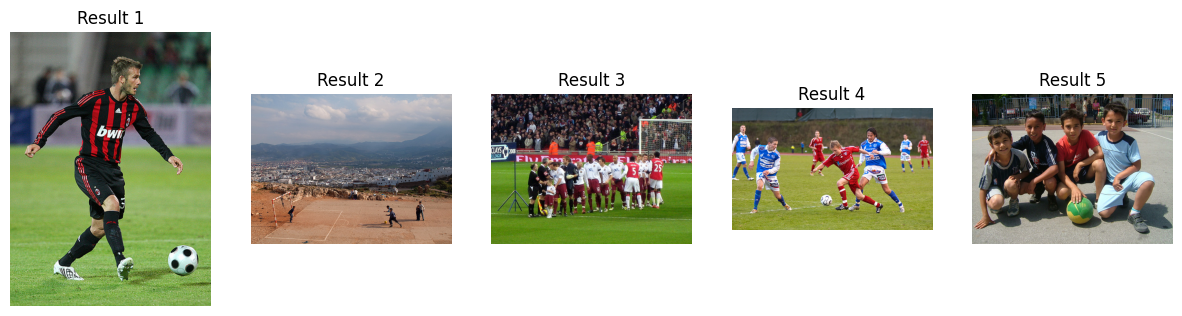

In [ ]:
import matplotlib.pyplot as plt
def search_by_text(query_text, k=5):
    text_inputs = processor(text=[query_text], return_tensors="pt", padding=True).to("cuda")

    with torch.no_grad():
        text_embedding = model.get_text_features(**text_inputs).cpu().numpy()

    if index.ntotal == 0:
        print("FAISS index is empty. No search results.")
        return []

    distances, indices = index.search(text_embedding, k)

    if indices.shape[1] == 0:
        print("No results found in FAISS.")
        return []

    return [image_names_list[i] for i in indices[0] if i < len(image_names_list)]


    import matplotlib.pyplot as plt

def search_by_text_and_display(query_text, k=5):
    results = search_by_text(query_text, k)


    fig, axes = plt.subplots(1, k, figsize=(15, 5))
    for i, image_name in enumerate(results):
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Result {i+1}")

    plt.show()


query = "playing football"
search_by_text_and_display(query)




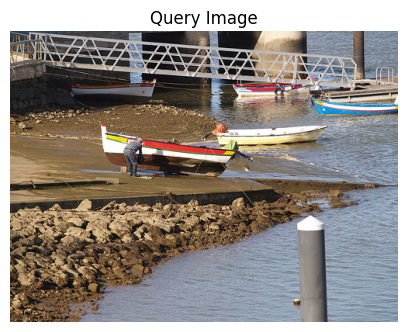

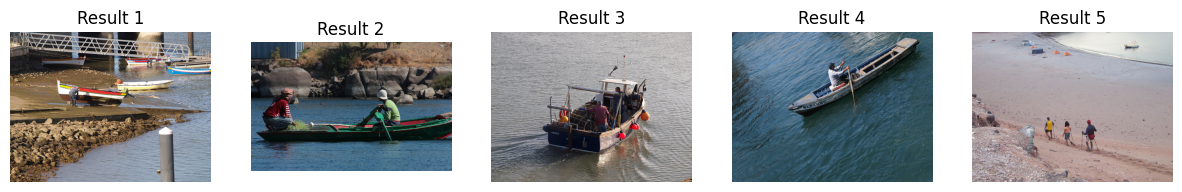

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import os
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_clip_embedding(image_path=None, text=None):
    if image_path:
        image = Image.open(image_path).convert("RGB")
        image_inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            image_embedding = model.get_image_features(**image_inputs).cpu().numpy()
        return image_embedding, None

    elif text:
        text_inputs = processor(text=[text], return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            text_embedding = model.get_text_features(**text_inputs).cpu().numpy()
        return None, text_embedding

def search_by_image(query_image_path, k=5):
    image_embedding, _ = get_clip_embedding(query_image_path, "")

    if image_embedding is None:
        print("Error: Image embedding could not be generated.")
        return []

    distances, indices = index.search(image_embedding, k)
    return [image_names_list[i] for i in indices[0]]


def search_by_image_and_display(query_image_path, k=5):
    results = search_by_image(query_image_path, k)

    # Display query image
    query_image = Image.open(query_image_path)
    plt.figure(figsize=(5, 5))
    plt.imshow(query_image)
    plt.axis("off")
    plt.title("Query Image")
    plt.show()

    # Display results
    fig, axes = plt.subplots(1, k, figsize=(15, 5))
    for i, image_name in enumerate(results):
        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path)
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(f"Result {i+1}")

    plt.show()

# Example usage
query_image_path = os.path.join(image_dir, image_text_pairs[12000][0])
search_by_image_and_display(query_image_path)



In [ ]:
import torch
from sklearn.metrics import precision_score


def search_by_text(query_text, k=5):
    text_inputs = processor(text=[query_text], return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        text_embedding = model.get_text_features(**text_inputs).cpu().numpy().astype(np.float32)


    distances, indices = index.search(text_embedding, k)


    retrieved_images = [image_names_list[i] for i in indices[0]]

    return retrieved_images


def evaluate_retrieval(query_text, ground_truth_index, k=5):
    retrieved_images = search_by_text(query_text, k)


    retrieved_indices = torch.tensor(
        [image_names_list.index(img) for img in retrieved_images], device="cuda"
    )


    y_true = torch.zeros(k, device="cuda")
    y_true[retrieved_indices == ground_truth_index] = 1


    y_pred = torch.ones(k, device="cuda")


    return precision_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='micro')


query_text = image_text_pairs[0][1]
ground_truth_index = 0
score = evaluate_retrieval(query_text, ground_truth_index)
print(f"✅ Precision@5: {score}")


✅ Precision@5: 0.0


In [ ]:

faiss.write_index(index, "/content/faiss_index.idx")
np.save("/content/image_names.npy", np.array(image_names_list))

print("FAISS index saved successfully.")


index = faiss.read_index("/content/faiss_index.idx")
image_names_list = np.load("/content/image_names.npy").tolist()

print("FAISS index loaded successfully.")



FAISS index saved successfully.
FAISS index loaded successfully.


In [ ]:
import torch
import faiss
import numpy as np


model.save_pretrained("/content/clip_model")
processor.save_pretrained("/content/clip_processor")


faiss.write_index(index, "/content/faiss_index.idx")


np.save("/content/image_names.npy", np.array(image_names_list))

print("Model and FAISS index saved successfully!")


Model and FAISS index saved successfully!


In [ ]:
from transformers import CLIPProcessor, CLIPModel


model = CLIPModel.from_pretrained("/content/clip_model").to("cuda")
processor = CLIPProcessor.from_pretrained("/content/clip_processor")


index = faiss.read_index("/content/faiss_index.idx")


image_names_list = np.load("/content/image_names.npy").tolist()

print("Model and FAISS index loaded successfully!")


Model and FAISS index loaded successfully!


In [ ]:
from google.colab import files
files.download("/content/faiss_index.idx")
files.download("/content/image_names.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>